# **Machine Learning - Tech Challenge_Fase 04 - Grupo 44**
Aluna responsável: Flora Serafim de Carvalho | RM354000

## Lendo a base de dados
Antes de iniciarmos o processamento, a primeira etapa consiste em trazer as informações da nossa base de dados. Ela foi consolidada em um arquivo ".csv", usando como base os dados disponibilizados pelo [IPEA](http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view), na qual traz o evolutivo diário do preço por barril do petróleo bruto tipo Brent.

As informações compreendem o período entre 20/05/1987 e 03/02/2025.


In [ ]:
import pandas as pd

In [ ]:
preco_petroleo_brent = pd.read_csv('https://raw.githubusercontent.com/florascarvalho/Postech_Data-Analytics_Tech-Challenge_Fase4/main/bases_dados/preco_petroleo_brent.csv', sep=";", decimal =",")
preco_petroleo_brent["data_dia"] = pd.to_datetime(preco_petroleo_brent["data_dia"], format="%d/%m/%Y")
preco_petroleo_brent.head()

,data_dia,preco_petroleo_bruto_Brent_FOB
0,2025-02-03,76.49
1,2025-01-31,77.11
2,2025-01-30,77.42
3,2025-01-29,77.02
4,2025-01-28,78.01


# Modelo de Machine Learning: ARIMA e SARIMAX

Para o desafio proposto, foi utilizado o modelo ARIMA/SARIMAX para a previsão de preço ao longo do tempo.

O primeiro passo é instalar os pacotes que serão utilizados e na sequência, importar as biliotecas necessárias para o desenvolvimento dos modelos.

In [ ]:
!pip install pmdarima
!pip install joblib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


from math import sqrt
from google.colab import files

def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

Abaixo, segue a visualização gráfica inicial dos dados, sem processamento.

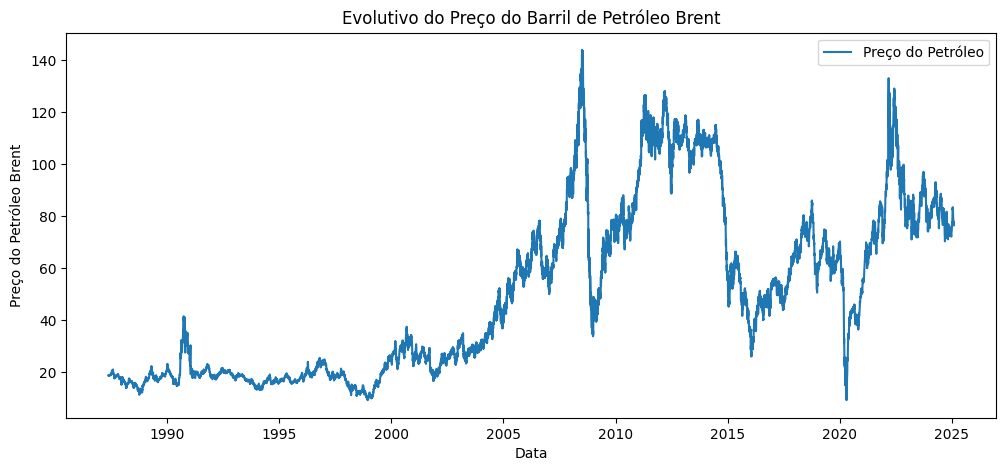

In [ ]:
# Visualização dos dados

plt.figure(figsize=(12, 5))
plt.plot(preco_petroleo_brent["data_dia"], preco_petroleo_brent["preco_petroleo_bruto_Brent_FOB"], label='Preço do Petróleo')
plt.title('Evolutivo do Preço do Barril de Petróleo Brent')
plt.xlabel('Data')
plt.ylabel('Preço do Petróleo Brent')
plt.legend()
plt.show()

Na base, há alguns dias que não possuem valores. Por isso deverá ser feito um resample dos dados, para que dessa forma os dias faltantes adote o valor do dia anterior. Dessa forma, teremos uma base contínua e sem "pulos" (necessária para a modelagem do Machine Learning).

In [ ]:
# Definição do resample
preco_petroleo_brent_resample = preco_petroleo_brent.set_index("data_dia").resample('1D').ffill()
preco_petroleo_brent_resample

,preco_petroleo_bruto_Brent_FOB
data_dia,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-23,18.55
1987-05-24,18.55
...,...
2025-01-30,77.42
2025-01-31,77.11
2025-02-01,77.11


## Teste de Dickey-Fuller

O teste de Dickey-Fuller é importante para o modelo ARIMA/SARIMAX pois verifica se os dados apresentados são estacionários ou não, ou seja, verifica se as propriedades estatísticas não mudam ao longo do tempo ou se apresentam alguma variação.

Para interpretar o resultado do teste de Dickey-Fuller (ADF), devemos verificar o valor resultante de <u>p-valor</u>, sendo:


*   p-valor ≤ 0.05 → Rejeitamos a hipótese nula → A série é estacionária.
*   p-valor > 0.05 → Não rejeitamos a hipótese nula → A série não é estacionária (precisa de transformação).





In [ ]:
from statsmodels.tsa.stattools import adfuller
testeADF = adfuller(preco_petroleo_brent["preco_petroleo_bruto_Brent_FOB"])


print('Estatística ADF: {:.4f}'.format(testeADF[0]))
print('p-valor: {:.4f}'.format(testeADF[1]))

if testeADF[1] <= 0.05:
    print("\n A série é estacionária, pode aplicar ARIMA/ SARIMAX")
else:
    print("\n A série NÃO é estacionária, necessário torná-la.")

Estatística ADF: -1.9615
p-valor: 0.3037

 A série NÃO é estacionária, necessário torná-la.


Como a série não é estacionária, devido ao fato de p-valor >0.05, é necessário adequar os valores para que se tornem estacionários, adequando-se para a utilização do modelo ARIMA/ SARIMAX.

A alternativa proposta abaixo, é recalcular o teste ADF aplicando diferenciação, ou seja, removendo as tendências.

In [ ]:
testADF = adfuller(preco_petroleo_brent["preco_petroleo_bruto_Brent_FOB"].diff().dropna())


print('Estatística ADF: {:.4f}'.format(testADF[0]))
print('p-valor: {:.4f}'.format(testADF[1]))

if testADF[1] <= 0.05 or testADF[1] == 0.0:
    print("\n A série é estacionária, pode aplicar ARIMA/ SARIMAX")
else:
    print("\n A série NÃO é estacionária, necessário torná-la.")


Estatística ADF: -17.5203
p-valor: 0.0000

 A série é estacionária, pode aplicar ARIMA/ SARIMAX


Como tornamos os dados estacionários, podemos começar  utilizar nosso modelo. Para isso, serão criadas duas variáveis: uma para o treino do modelo (usando dados entre 1987 até 2015), e outra para o teste do modelo (dados à partir de 2016).

In [ ]:
# Definição dos parâmetro do treino e teste
treino_modelo_ARIMA = preco_petroleo_brent_resample[:'2015-12-31']
teste_modelo_ARIMA = preco_petroleo_brent_resample['2016-01-01':]

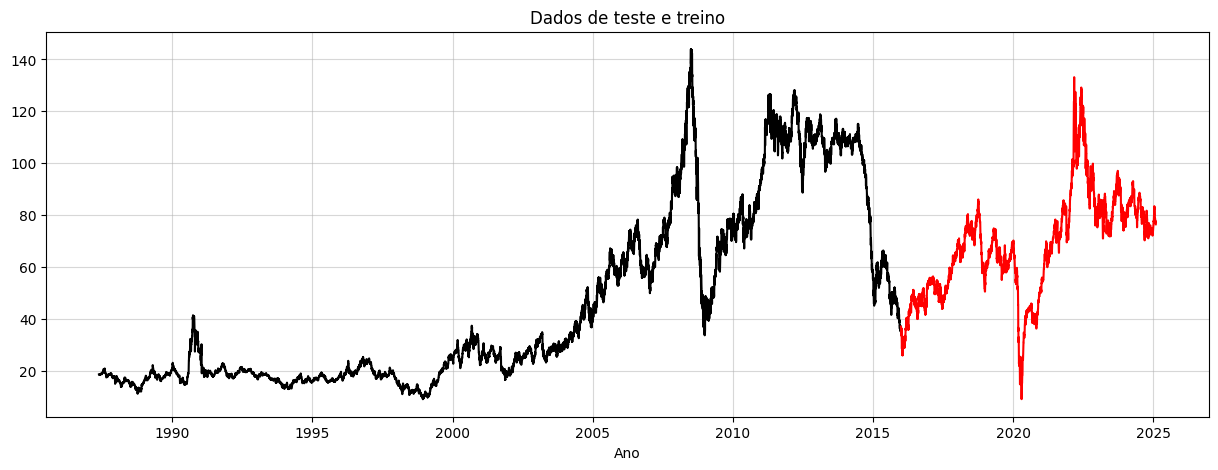

In [ ]:
# Plotagem do gráfico com os dados de treino e teste
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(treino_modelo_ARIMA, 'black', teste_modelo_ARIMA, 'red')
plt.title("Dados de teste e treino")
plt.xlabel('Ano')
plt.grid(alpha=0.5)
plt.show()

In [ ]:
print(f'Qtd de dados de treino: {treino_modelo_ARIMA.shape[0]} \n\nQtd de dados de teste: {teste_modelo_ARIMA.shape[0]}')

Qtd de dados de treino: 10453 

Qtd de dados de teste: 3322


In [ ]:
## P=1, D=1 e Q=1

modelo_arima = ARIMA(treino_modelo_ARIMA, order =(1,1,1))
arima_info = modelo_arima.fit()
print(arima_info.summary())

                                     SARIMAX Results                                      
Dep. Variable:     preco_petroleo_bruto_Brent_FOB   No. Observations:                10453
Model:                             ARIMA(1, 1, 1)   Log Likelihood              -16971.919
Date:                            Sat, 15 Feb 2025   AIC                          33949.837
Time:                                    21:50:58   BIC                          33971.601
Sample:                                05-20-1987   HQIC                         33957.188
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2803      0.017     16.497      0.000       0.247       0.314
ma.L1         -0.5576      0.015   

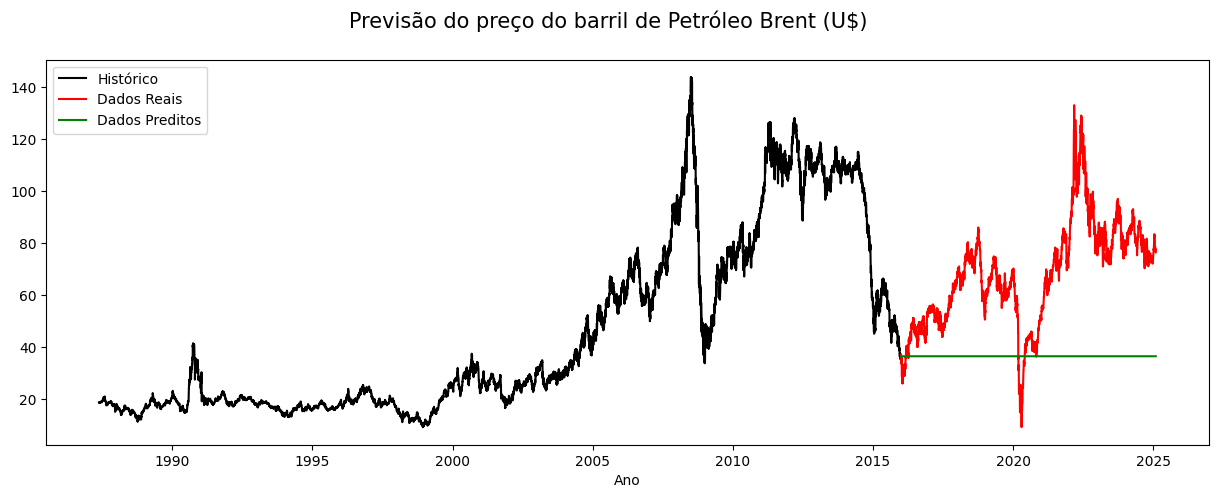

In [ ]:
# Criação da variável com os dados de predição do modelo ARIMA
predicao_ARIMA = arima_info.predict(treino_modelo_ARIMA.shape[0], preco_petroleo_brent_resample.shape[0]-1, dynamic=True)
predicao_ARIMA.shape


# Plotando gráfico com a visualização dos dados do treino e teste
fig, ax = plt.subplots(figsize = (15,5))
fig.suptitle('Previsão do preço do barril de Petróleo Brent (U$)', fontsize=15)

treino, = plt.plot(treino_modelo_ARIMA.loc['1987-05-20':],"black", label = "Histórico")
teste, = plt.plot(teste_modelo_ARIMA, "red", label = "Dados Reais")
predicao, = plt.plot(predicao_ARIMA, "green", label = "Dados Preditos")

plt.legend(handles=[treino, teste, predicao], fontsize=10)
plt.xlabel('Ano', fontsize=10)

plt.show()

In [ ]:
import math

# Avaliação das Métricas do modelo ARIMA
mae_arimam = mean_absolute_error(teste_modelo_ARIMA.values, predicao_ARIMA.values)
mse_arimam = mean_squared_error(teste_modelo_ARIMA.values, predicao_ARIMA.values)
rmse_arimam = math.sqrt(mse_arimam)
mape_arimam = mean_absolute_percentage_error(teste_modelo_ARIMA.values, predicao_ARIMA.values)
wmape_arimam = wmape(teste_modelo_ARIMA.values, predicao_ARIMA.values)

print(f"MAE - Erro Médio Absoluto: {mae_arimam:.5f}")
print(f"MSE - Erro Médio Quadrático: {mse_arimam:.5f}")
print(f"RMSE - Raiz do Erro Médio Quadrático: {rmse_arimam:.5f}")
print(f"MAPE - Erro Percentual Absoluto Médio: {mape_arimam:.2%}")
print(f"WMAPE - Erro Percentual Absoluto Médio Ponderado: {wmape_arimam:.2%}")


MAE - Erro Médio Absoluto: 32.15703
MSE - Erro Médio Quadrático: 1378.81474
RMSE - Raiz do Erro Médio Quadrático: 37.13239
MAPE - Erro Percentual Absoluto Médio: 43.74%
WMAPE - Erro Percentual Absoluto Médio Ponderado: 157476.19%


A etapa seguinte é verificar qual dos parâmetros do ARIMA reflete em um melhor modelo. Obtendo essa informação, conseguimos dimensionar as informações de forma mais acertiva para o SARIMAX.

In [ ]:
melhor_arima = auto_arima(
    preco_petroleo_brent_resample, d=1,
    start_p=1, start_q=1, max_p=2, max_q=2,
    seasonal=True, m=7, D=1,
    start_P=0, start_Q=0, max_P=1, max_Q=1,
    max_order=5,  information_criterion="aic", stepwise=True, n_jobs=-1,
    suppress_warnings=True, error_action="ignore", trace=True
)

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=24.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[7]             : AIC=56437.361, Time=1.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[7]             : AIC=52142.718, Time=2.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=22.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,0)[7]             : AIC=56211.063, Time=0.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=25.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[7]             : AIC=inf, Time=18.60 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,1,0)[7]             : AIC=52382.671, Time=1.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[7]             : AIC=51550.668, Time=5.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,0)[7]             : AIC=55653.951, Time=1.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=37.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,1,1)[7]             : AIC=inf, Time=16.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[7]             : AIC=51485.956, Time=6.72 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,0)[7]             : AIC=inf, Time=17.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,1)[7]             : AIC=inf, Time=43.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,1)[7]             : AIC=inf, Time=32.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[7]             : AIC=inf, Time=27.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,0)[7]             : AIC=inf, Time=29.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,1,0)[7]             : AIC=51581.947, Time=5.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,0)[7] intercept   : AIC=51487.956, Time=24.97 sec

Best model:  ARIMA(2,1,1)(1,1,0)[7]          
Total fit time: 346.725 seconds


In [ ]:
# Como o melhor modelo foi o ARIMA (2,1,1)(1,1,0)[7], serão adotados esses parâmetros para o SARIMAX
modelo_sarimax = SARIMAX(preco_petroleo_brent_resample, order=(2,1,1), seasonal_order=(1,1,0,7))
resultado_sarimax = modelo_sarimax.fit()

resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:     preco_petroleo_bruto_Brent_FOB   No. Observations:                13775
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 7)   Log Likelihood              -25737.978
Date:                            Sat, 15 Feb 2025   AIC                          51485.956
Time:                                    21:56:54   BIC                          51523.606
Sample:                                05-20-1987   HQIC                         51498.501
                                     - 02-03-2025                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0582      0.024      2.476      0.013       0.012       0.104
ar.L2         -0.1822      0.007    -27.891      0.000      -0.195      -0.169
ma.L1         -0.2288      0.024     -9.587      0.000      -0.276      -0.182
ar.S.L7       -0.5056      0.003   -146.877      0.000      -0.512      -0.499
sigma2         2.4622      0.011    218.693      0.000       2.440       2.484
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):             83778.19
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):              12.77   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX

In [ ]:
# Definição da confiabilidade dos resultados, definindo os limites inferiores e superiores para plotagem do gráfico.
predicao_sarimax = resultado_sarimax.get_prediction(start=-30)
predicao_media = predicao_sarimax.predicted_mean

intervalo_confianca = predicao_sarimax.conf_int()
limite_inferior = intervalo_confianca.iloc[:,0]
limite_superior = intervalo_confianca.iloc[:,1]

limite_abaixo[0], limite_acima[0]

<ipython-input-83-417ecd578e94>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  limite_abaixo[0], limite_acima[0]


(73.39025061657401, 79.54111106555862)

In [ ]:
## Gerando a predição para plotagem no gráfico
datas_predicao = np.asarray(predicao_media.index)
datas = np.asarray(preco_petroleo_brent_resample.index)

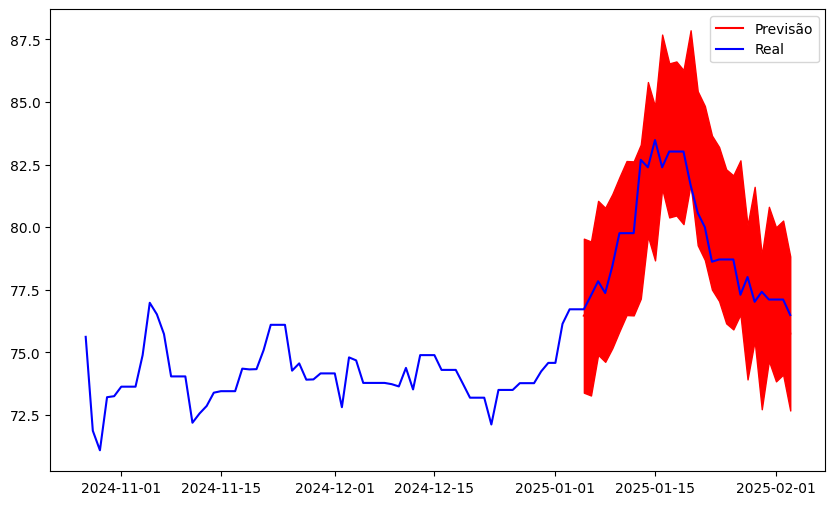

In [ ]:
## Plotagem dos dados aplicando SARIMAX
plt.figure(figsize=(10,6))
plt.plot(datas_predicao,predicao_media.values, color="red", label="Previsão")
plt.fill_between(datas_predicao, limite_inferior, limite_superior, color="red")
plt.plot(datas[-100:],preco_petroleo_brent_resample[-100:].values, color="blue", label="Real")
plt.legend()
plt.show()

In [ ]:
# Avaliação das Métricas do modelo SARIMAX

mae_sarimax = mean_absolute_error(preco_petroleo_brent_resample[-30:].values, predicao_media.values)
mse_sarimax = mean_squared_error(preco_petroleo_brent_resample[-30:].values, predicao_media.values)
rmse_sarimax = math.sqrt(mse_sarimax)
mape_sarimax = mean_absolute_percentage_error(preco_petroleo_brent_resample[-30:].values, predicao_media.values)
wmape_sarimax = wmape(preco_petroleo_brent_resample[-30:].values, predicao_media.values)

print(f"MAE - Erro Médio Absoluto: {mae_sarimax:.5f}")
print(f"MSE - Erro Médio Quadrático: {mse_sarimax:.5f}")
print(f"RMSE - Raiz do Erro Médio Quadrático: {rmse_sarimax:.5f}")
print(f"MAPE - Erro Percentual Absoluto Médio: {mape_sarimax:.2%}")
print(f"WMAPE - Erro Percentual Absoluto Médio Ponderado: {wmape_sarimax:.2%}")


MAE - Erro Médio Absoluto: 0.99625
MSE - Erro Médio Quadrático: 1.69494
RMSE - Raiz do Erro Médio Quadrático: 1.30190
MAPE - Erro Percentual Absoluto Médio: 1.25%
WMAPE - Erro Percentual Absoluto Médio Ponderado: 105.82%


## Realizando a previsão do Forecast com SARIMAX

In [ ]:
forecast_sarimax = resultado_sarimax.get_forecast(steps=30)
forecast_medio = forecast_sarimax.predicted_mean

pd.DataFrame(forecast_sarimax.predicted_mean.head()).rename(columns={"predicted_mean":"preco_petroleo_bruto_Brent_FOB"})

,preco_petroleo_bruto_Brent_FOB
2025-02-04,76.155247
2025-02-05,75.232842
2025-02-06,74.747197
2025-02-07,74.666632
2025-02-08,74.665614


In [ ]:
intervalo_confianca_forecast = forecast_sarimax.conf_int()
limite_inferior_f = intervalo_confianca_forecast.iloc[:,0]
limite_superior_f = intervalo_confianca_forecast.iloc[:,1]

limite_inferior_f[0], limite_superior_f[0]

<ipython-input-88-427ead768587>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  limite_inferior_f[0], limite_superior_f[0]


(73.0798170367161, 79.23067748570071)

In [ ]:
forecast_medio[0]

<ipython-input-89-022acc7499ae>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_medio[0]


76.1552472612084

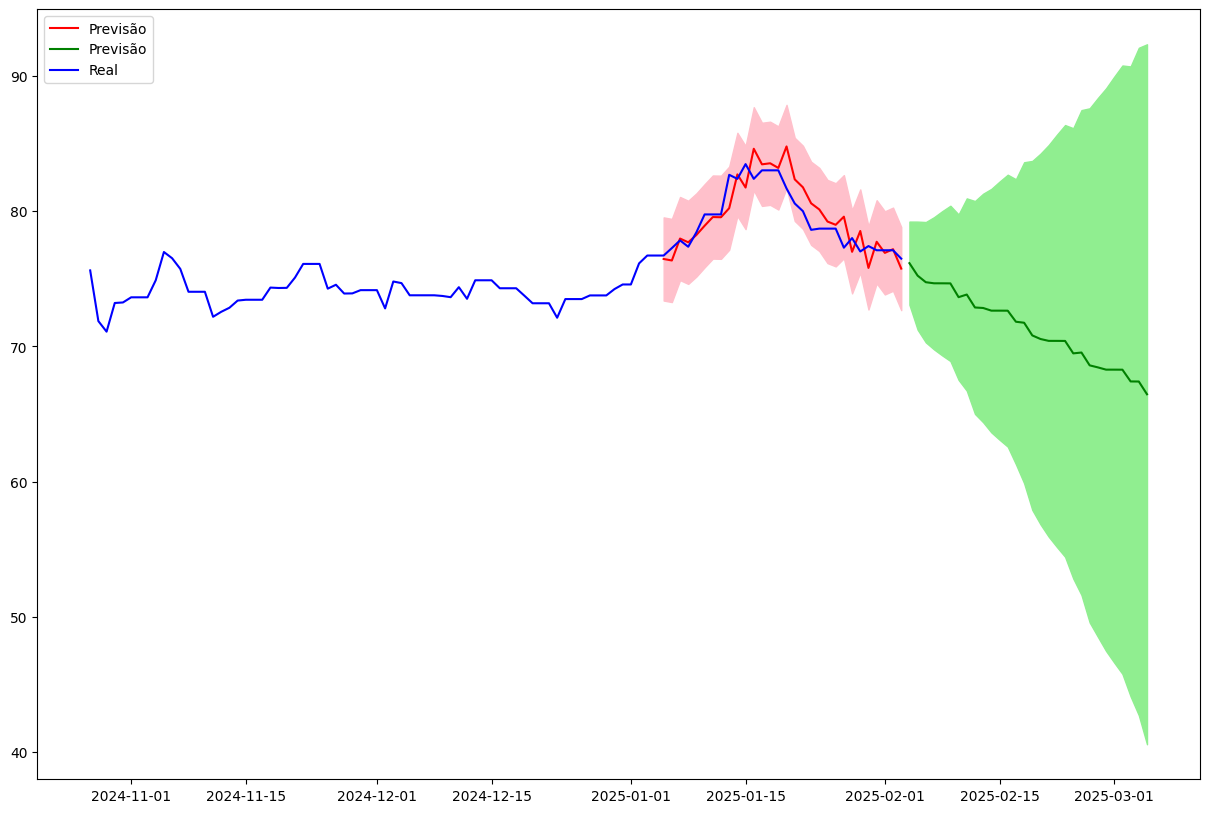

In [ ]:
datas_forecast = np.asarray(forecast_medio.index)
datas = np.asarray(preco_petroleo_brent_resample.index)

plt.figure(figsize=(15,10))

plt.plot(datas_predicao,predicao_media.values, color="red", label="Previsão")
plt.fill_between(datas_predicao, limite_inferior, limite_superior, color="pink")

plt.plot(datas_forecast,forecast_medio.values, color="green", label="Previsão")
plt.fill_between(datas_forecast, limite_inferior_f, limite_superior_f, color="lightgreen")

plt.plot(datas[-100:],preco_petroleo_brent_resample[-100:].values, color="blue", label="Real")
plt.legend(loc='upper left')
plt.show()

Vamos importar nosso modelo para um arquivo joblib

In [ ]:
import os
import joblib

# Create the 'modelo' directory if it doesn't exist
if not os.path.exists('modelo'):
    os.makedirs('modelo')

# Now you can save the model
joblib.dump(modelo_sarimax, 'modelo/sarimax.joblib', compress=3)

['modelo/sarimax.joblib']

A última etapa é extrair essas previsões para um arquivo ".csv", para que possamos utilizar na interface de Power BI.

In [ ]:
# Criar DataFrame com as duas colunas, arredondando a coluna "preco" para 2 casas decimais
df_forecast = pd.DataFrame({
    "data": datas_forecast,
    "preco": forecast_medio.values
})

# Arredondar a coluna "preco" para 2 casas decimais
df_forecast["preco"] = df_forecast["preco"].round(2)

# Salvar o DataFrame em um arquivo CSV
df_forecast.to_csv("previsoes.csv", index=False)